 ## Package Load

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)
print(os.listdir("../input"))

['WSampleSubmissionStage1.csv', 'stage2wdatafiles', 'wdatafiles', 'WSampleSubmissionStage2.csv']


# Data Load

In [2]:
tourney_results = pd.read_csv('../input/stage2wdatafiles/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/stage2wdatafiles/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/stage2wdatafiles/WRegularSeasonDetailedResults.csv')

# Data Preprocessing

Because of the data structure, which differentiate the home team and away team in training data, so one game match could have one record, which has seperate columns to feature the statistics of two teams. Directly modeling on this structure would lose some information since one record could be seemed as two perspective in both teams. So the strategy here is to duplicate the original data into a mirror record. And all the data preprocessing and feature engineering would be done in both original data and mirror data in the same way.

In [3]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [4]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

## Feature Engineering

There are so many features could be used for modeling, which could easily cause overfitting, the strategy here is to choose some important features to model. I tried several functions based on those features but also easy to get overfitting, the model has the best generalization power only includes mean function.

In [5]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean] #+ [max, min, np.std]

In [6]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,19.148148,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,22.068966,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862


In [7]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

Add features based on a small window.

In [8]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [9]:
all_stats_T1 = regular_data.reset_index(drop=True)
all_stats_T1['win'] = np.where(all_stats_T1['PointDiff']>0,1,0)
all_stats_T1 = all_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_all')

all_stats_T2 = regular_data.reset_index(drop=True)
all_stats_T2['win'] = np.where(all_stats_T2['PointDiff']<0,1,0)
all_stats_T2 = all_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_all')

In [10]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(5638, 5)

Using generalized linear regression on the result of each match for each team, got the alpha (interception on y-axis) as the proxy for the team quality, this feature is based on each season window.

In [11]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [12]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019)]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove 

In [13]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

Seeds features.

In [14]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [15]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2010,138,3124,69,3201,55
1,2010,138,3173,67,3395,66
2,2010,138,3181,72,3214,37
3,2010,138,3199,75,3256,61
4,2010,138,3207,62,3265,42


Merge all features into the tourney level data for modeling.

In [16]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, all_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, all_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Model

In [17]:
train = tourney_data
train = tourney_data[tourney_data.Season!=2018].reset_index()

In [18]:
y = train['T1_Score'] - train['T2_Score']
y.describe()

count    1008.000000
mean        0.000000
std        21.323163
min       -89.000000
25%       -14.000000
50%         0.000000
75%        14.000000
max        89.000000
dtype: float64

In [19]:
# y = train['T1_Score'] > train['T2_Score']
# y.describe()

In [20]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    list(all_stats_T1.columns[2:999]) + \
    list(all_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

47

Use xgboost as the model.

In [21]:
X = train[features].values
dtrain = xgb.DMatrix(X, label = y)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Since we use MAE as the loss function, which is not second differenciable, but XGboost need the second order difference, so we use cauchy equation to approximate the hessian matrix.

In [22]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 3000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [23]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.01 
param['subsample'] = 0.35
param['colsample_bytree'] = 0.8
param['num_parallel_tree'] = 10 
param['min_child_weight'] = 40
param['gamma'] = 5
param['max_depth'] =  5
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.01, 'subsample': 0.35, 'colsample_bytree': 0.8, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 5, 'max_depth': 5, 'silent': 1}


To estimate the optimal boosting round, here I use 5 different seeds, and within each seed, I use 8 fold cross validation to estimate the best boost round, save the results.

In [24]:
xgb_cv = []
repeat_cv = 5 

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 8, shuffle = True, random_state = i+666),
          early_stopping_rounds = 40,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.739+0.167135	test-mae:16.743+1.17929
[50]	train-mae:13.3845+0.080268	test-mae:13.5397+0.806571
[100]	train-mae:11.6764+0.0618952	test-mae:11.9963+0.563962
[150]	train-mae:10.7883+0.0623625	test-mae:11.2666+0.45807
[200]	train-mae:10.2632+0.0629196	test-mae:10.884+0.427459
[250]	train-mae:9.89744+0.064782	test-mae:10.6641+0.4208
[300]	train-mae:9.61709+0.0602831	test-mae:10.5241+0.42767
[350]	train-mae:9.38422+0.0559547	test-mae:10.4313+0.428962
[400]	train-mae:9.18285+0.0517961	test-mae:10.3655+0.421223
[450]	train-mae:9.00379+0.0475068	test-mae:10.3147+0.414299
[500]	train-mae:8.84162+0.0445441	test-mae:10.2692+0.401175
[550]	train-mae:8.69256+0.0429516	test-mae:10.2392+0.393815
[600]	train-mae:8.55413+0.041728	test-mae:10.2171+0.378181
[650]	train-mae:8.42528+0.0404138	test-mae:10.198+0.363691
[700]	train-mae:8.30409+0.040119	test-mae:10.1817+0.34935
[750]	train-mae:8.19054+0.0389945	test-mae:10.1689+0.338138
[800]	train-mae:8.08163+0.0376564	test-mae

In [25]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([1293, 1014, 1040, 885, 873],
 [10.085156875, 10.152741875, 10.251944, 10.25454, 10.202671125000002])

Use the estimated best round to make the whole prediction for the training data, use 5-fold cross validation.

In [26]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


Go to the next stage model, firstly check the win rate for each integer prediction.

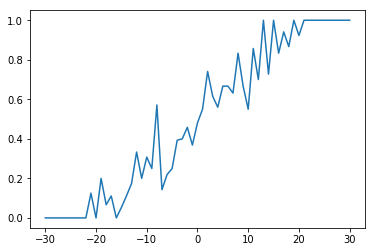

In [27]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

There are some strikes for the prediction line, and not Monotonically increasing, so here I use spline interporlation to smooth the prediction for the second stage.

In [28]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.4262704674606808
logloss of cvsplit 1: 0.42579438965873484
logloss of cvsplit 2: 0.4259592853662835
logloss of cvsplit 3: 0.4250627061729696
logloss of cvsplit 4: 0.42810660907128123


Check the predictions before and after spline smoothing.

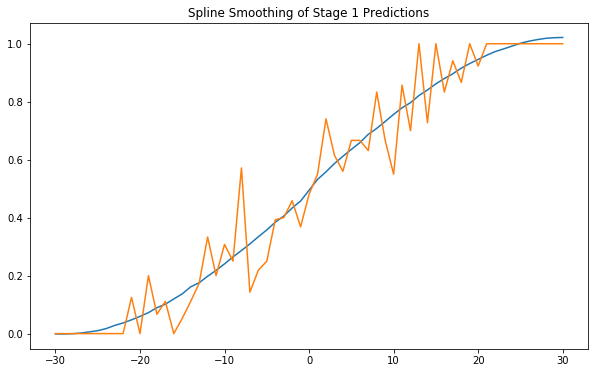

In [29]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.title('Spline Smoothing of Stage 1 Predictions')
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

More tricks:
 - Clip the extreme predictions, since the evaluation metric is log-loss, which is sensitive to extreme values, and the marginal for those extreme predictions are small but risk is large.
 - Mannually change the predictions for some cases with really small probability, like upsets.

Firstly, just check the clip influence.

In [30]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4303563426847371
adjusted logloss of cvsplit 1: 0.4298707016027944
adjusted logloss of cvsplit 2: 0.42937594231540877
adjusted logloss of cvsplit 3: 0.42895194839260165
adjusted logloss of cvsplit 4: 0.4320416604813673


Then check manually upset setting influence.
Set the first four seeds win rate to be 100%.

In [31]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(train.T1_seed==1) & (train.T2_seed==16)] = 1.0
    spline_fit[(train.T1_seed==2) & (train.T2_seed==15)] = 1.0
    spline_fit[(train.T1_seed==3) & (train.T2_seed==14)] = 1.0
    spline_fit[(train.T1_seed==4) & (train.T2_seed==13)] = 1.0
    spline_fit[(train.T1_seed==16) & (train.T2_seed==1)] = 0.0
    spline_fit[(train.T1_seed==15) & (train.T2_seed==2)] = 0.0
    spline_fit[(train.T1_seed==14) & (train.T2_seed==3)] = 0.0
    spline_fit[(train.T1_seed==13) & (train.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4754485415775265
adjusted logloss of cvsplit 1: 0.4744012734484976
adjusted logloss of cvsplit 2: 0.47360666188789063
adjusted logloss of cvsplit 3: 0.4741932874352704
adjusted logloss of cvsplit 4: 0.4756121382838245


It seems the mannually setting upset would make the model much worse, but this could because of the few cases happened in certain years, so need to continuely check the upset situation in different years.

In [32]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_win_ratio_all,T2_win_ratio_all,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
718,2012,139,3208,70,3265,76,26.137931,61.0000,4.551724,14.62069,14.586207,12.931034,14.931034,10.758621,16.344828,21.206897,55.724138,4.862069,16.62069,13.37931,10.965517,19.724138,6.931034,3.482759,10.827586,23.156250,55.3125,7.031250,21.96875,9.281250,15.343750,13.906250,9.687500,12.937500,20.062500,57.937500,5.718750,17.84375,13.81250,11.218750,16.843750,7.125000,2.468750,9.781250,0.0,1.0,0.724138,0.781250,inf,inf,4,13,-9
151,2012,139,3265,76,3208,70,23.156250,55.3125,7.031250,21.96875,9.281250,15.343750,13.906250,9.687500,12.937500,20.062500,57.937500,5.718750,17.84375,13.81250,11.218750,16.843750,7.125000,2.468750,9.781250,26.137931,61.0000,4.551724,14.62069,14.586207,12.931034,14.931034,10.758621,16.344828,21.206897,55.724138,4.862069,16.62069,13.37931,10.965517,19.724138,6.931034,3.482759,10.827586,1.0,0.0,0.781250,0.724138,inf,inf,13,4,9


So actually there are only one case that the upset happened in our dataset. In 2012, the seed 13 team beat the seed 4 team, it would be safe to manually set this prediction in my view. Check the influence after ignoring this case.

In [33]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(train.T1_seed==1) & (train.T2_seed==16) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==2) & (train.T2_seed==15) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==3) & (train.T2_seed==14) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==4) & (train.T2_seed==13) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==16) & (train.T2_seed==1) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==15) & (train.T2_seed==2) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==14) & (train.T2_seed==3) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==13) & (train.T2_seed==4) & (train.T1_Score < train.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4117058200877926
adjusted logloss of cvsplit 1: 0.41106006468287637
adjusted logloss of cvsplit 2: 0.4107297248548715
adjusted logloss of cvsplit 3: 0.4105992750646347
adjusted logloss of cvsplit 4: 0.41269087946919186


Now the model performance boost a lot after the manual setting, also need to check the clip influence based on this.

In [34]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(train.T1_seed==1) & (train.T2_seed==16) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==2) & (train.T2_seed==15) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==3) & (train.T2_seed==14) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==4) & (train.T2_seed==13) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==16) & (train.T2_seed==1) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==15) & (train.T2_seed==2) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==14) & (train.T2_seed==3) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==13) & (train.T2_seed==4) & (train.T1_Score < train.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.412883460051705
adjusted logloss of cvsplit 1: 0.4123511736037952
adjusted logloss of cvsplit 2: 0.4118069403001559
adjusted logloss of cvsplit 3: 0.41163721704281087
adjusted logloss of cvsplit 4: 0.4138679736428501


Nothing improve, so keep the raw predictions.

In [35]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(train.T1_seed==1) & (train.T2_seed==16) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==2) & (train.T2_seed==15) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==3) & (train.T2_seed==14) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==4) & (train.T2_seed==13) & (train.T1_Score > train.T2_Score)] = 1.0
    spline_fit[(train.T1_seed==16) & (train.T2_seed==1) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==15) & (train.T2_seed==2) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==14) & (train.T2_seed==3) & (train.T1_Score < train.T2_Score)] = 0.0
    spline_fit[(train.T1_seed==13) & (train.T2_seed==4) & (train.T1_Score < train.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":train.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4117058200877926
adjusted logloss of cvsplit 1: 0.41106006468287637
adjusted logloss of cvsplit 2: 0.4107297248548715
adjusted logloss of cvsplit 3: 0.4105992750646347
adjusted logloss of cvsplit 4: 0.41269087946919186


season
2010    0.409550
2011    0.365297
2012    0.406766
2013    0.400591
2014    0.403864
2015    0.339666
2016    0.499623
2017    0.465500
dtype: float64

## Prediction

In [36]:
sub = pd.read_csv('../input/WSampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2019_3101_3113,0.5
1,2019_3101_3114,0.5
2,2019_3101_3120,0.5
3,2019_3101_3124,0.5
4,2019_3101_3125,0.5


In [37]:
sub.shape

(2016, 2)

In [38]:
sub["Season"] = 2019
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_3101_3113,0.5,2019,3101,3113
1,2019_3101_3114,0.5,2019,3101,3114
2,2019_3101_3120,0.5,2019,3101,3120
3,2019_3101_3124,0.5,2019,3101,3124
4,2019_3101_3125,0.5,2019,3101,3125


In [39]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, all_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, all_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

In [40]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [41]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.1),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [42]:
sub.shape

(2016, 52)

## Submission

In [43]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.05,0.95))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed.isin([16,15,14,13,12,8,9,10,11,7])), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed.isin([16,15,14,13,12,10,11])), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed.isin([16,15,14,13,12])), 'Pred'] = 1.0
# sub.loc[(sub.T1_seed==4) & (sub.T2_seed.isin([16,15,14,13,12])), 'Pred'] = 1.0
sub.loc[(sub.T1_seed.isin([16,15,14,13,12,8,9,10,11,7]) & (sub.T2_seed==1)), 'Pred'] = 0.0
sub.loc[(sub.T1_seed.isin([16,15,14,13,12]) & (sub.T2_seed==2)), 'Pred'] = 0.0
sub.loc[(sub.T1_seed.isin([16,15,14,13,12]) & (sub.T2_seed==3)), 'Pred'] = 0.0
# sub.loc[(sub.T1_seed.isin([16,15,14,13,12]) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("paris-submission.csv", index = None)